https://skimai.com/fine-tuning-bert-for-sentiment-analysis/

# Import Libraries

In [1]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Laptop GPU


# Load Data

In [3]:
# load all places
amusements = pd.read_excel('./20_places.xlsx')['Place']

print(f"Number of amusements: {len(amusements)}")
amusements

Number of amusements: 20


0                               Arab Street
1      Buddha Tooth Relic Temple and Museum
2                               Clarke Quay
3                        Gardens by the Bay
4                          Jurong Bird Park
5     ArtScience Museum at Marina Bay Sands
6                       Maxwell Food Centre
7                              Merlion Park
8                            Mustafa Centre
9              National Museum of Singapore
10                   National Orchid Garden
11                             Night Safari
12                             Orchard Road
13                            River Wonders
14           Sands Skypark Observation Deck
15                          Singapore Flyer
16                          Singapore River
17                            Singapore Zoo
18                Singapore Botanic Gardens
19        Singapore Mass Rapid Transit SMRT
Name: Place, dtype: object

In [4]:
# Load data and set labels

data_df = pd.DataFrame()
for amusement in amusements:
    file = f'./SentenceTrainData/train-label-{amusement}.csv'
    df = pd.read_csv(file)[['aspect', 'review_text', 'model_label', 'label']]
    
    data_df = pd.concat([data_df, df], ignore_index=True)

data_df['aspect'] = [aspect.replace('\'','').replace('[','').replace(']','') for aspect in data_df['aspect']]

data_df['input'] = [ aspect + ' [SEP] ' + text for aspect, text in zip(data_df['aspect'], data_df['review_text']) ]

In [5]:
data_df.head(5)

,aspect,review_text,model_label,label,input
0,Culture & Religion,If you are ready to get out of the malls of Or...,NaN,NEU,Culture & Religion [SEP] If you are ready to g...
1,Culture & Religion,I visited Arab Street on a Monday night in sea...,NEU,NEU,Culture & Religion [SEP] I visited Arab Street...
2,Shopping,If you want to have Shisha,NEU,NEU,Shopping [SEP] If you want to have Shisha
3,Transportation & Accessibility,Not far from the MRT station and about a 1km w...,NEU,NEU,Transportation & Accessibility [SEP] Not far f...
4,Culture & Religion,There are lots of specialty fabric stores and ...,POS,POS,Culture & Religion [SEP] There are lots of spe...


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
encoder = LabelEncoder()

X = data_df['input']
y = data_df['label']

# Fit the encoder and transform the labels
y_encoded = encoder.fit_transform(y)

data_df['label_encoded'] = y_encoded

In [7]:
data_df.sample(10)

,aspect,review_text,model_label,label,input,label_encoded
491,Transportation & Accessibility,"The closest MRT station is Chinatown, or from ...",NEU,NEU,Transportation & Accessibility [SEP] The close...,1
3553,Transportation & Accessibility,Getting there is a bit of a hassle as it's not...,NEG,NEG,Transportation & Accessibility [SEP] Getting t...,0
2855,History,one can choose his/her own path in the museum ...,NaN,POS,History [SEP] one can choose his/her own path ...,2
2059,Food Variety,"Get to the Stall with the Biggest Q, that way ...",NaN,POS,Food Variety [SEP] Get to the Stall with the B...,2
4326,Facilities,If u want to go view u buy a ticket 30 SGD and...,NEU,NEU,Facilities [SEP] If u want to go view u buy a ...,1
5601,Biodiversity,This site was easily accessible by MRT with a ...,NEU,NEU,Biodiversity [SEP] This site was easily access...,1
5524,Events,The cafe near Halia was very disappointing and...,NEG,NEG,Events [SEP] The cafe near Halia was very disa...,0
3815,Budget Shopping & Market,All the malls have excellent food halls with a...,POS,POS,Budget Shopping & Market [SEP] All the malls h...,2
5477,Biodiversity,It was recently declared a Unesco World Herita...,NEU,NEU,Biodiversity [SEP] It was recently declared a ...,1
850,View,Unfortunately the blaring music and ear-splitt...,NEG,NEG,View [SEP] Unfortunately the blaring music and...,0


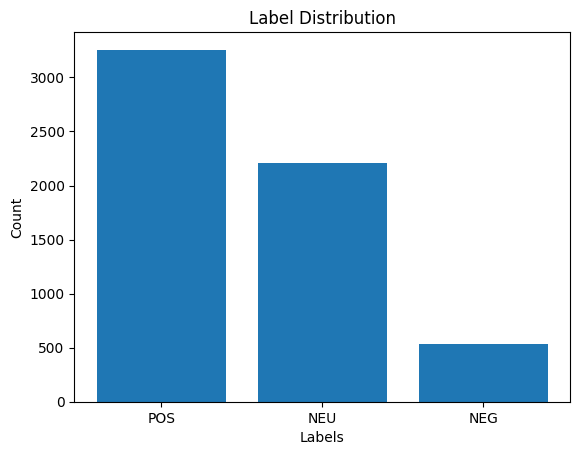

In [8]:
label_counts = data_df['label'].value_counts()

# Extract the labels and their counts
labels = label_counts.index
counts = label_counts.values

# Plot the bar chart
plt.bar(labels, counts)

# Set the chart title and axis labels
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

# Rotate x-axis labels if needed
plt.xticks()

# Display the chart
plt.show()

In [9]:
labels

Index(['POS', 'NEU', 'NEG'], dtype='object', name='label')

In [10]:
label_encoded = encoder.transform(['POS', 'NEU', 'NEG'])
label_encoded

array([2, 1, 0])

In [11]:
labels_decoded = encoder.inverse_transform([2, 1, 0])
labels_decoded

array(['POS', 'NEU', 'NEG'], dtype=object)

In [12]:
counts

array([3256, 2212,  532], dtype=int64)

In [13]:
# data is imbalanced adjust weights
total_samples = len(data_df['label_encoded'])
weights = []
for i in range(len(counts)):
    weights.append(total_samples/counts[label_encoded[i]])

weights = [w/sum(weights) for w in weights]
weights

[0.7123029718982267, 0.17131337298818108, 0.11638365511359232]

In [14]:

# Split train, val, test to be 80%, 10%, 10%

# split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(X, y_encoded, train_size=0.8)

X_val, X_test, y_val, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print('train, validation, test dataset size:')
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

train, validation, test dataset size:
(4800,) (4800,)
(600,) (600,)
(600,) (600,)


In [15]:
y_train

array([2, 2, 2, ..., 1, 2, 2])

In [16]:
labels = list(y_train)
total_count = len(labels)
weights = []
# Calculate distribution

print("Distribution:")
for i in range(len(set(labels))):
    count = labels.count(i)
    dist = count/total_count
    weights.append(1/dist)
    print(f"Class {i}: {count} {dist*100:.2f}%")

# Calculate class weights
weights = [w/sum(weights) for w in weights]
weights

Distribution:
Class 0: 432 9.00%
Class 1: 1781 37.10%
Class 2: 2587 53.90%


[0.7094467052731244, 0.17208364776978646, 0.1184696469570892]

In [17]:
# # Assuming y_train is a pandas DataFrame
# train_data = pd.DataFrame(data = {"input":X_train, "label": y_train})

# # Seperate each class' observations
# pos_class = train_data[train_data['label'] == 2]
# neu_class = train_data[train_data['label'] == 1]
# neg_class = train_data[train_data['label'] == 0]

# print(pos_class.shape, neu_class.shape, neg_class.shape)
# # Downsample major classes
# pos_downsampled = pos_class.sample(1000, replace=False, random_state=42)
# neu_downsampled = neu_class.sample(1000, replace=False, random_state=42)

# # Combine downsampled majority class with minority class
# train_data_downsampled = pd.concat([pos_downsampled, neu_downsampled, neg_class])

# # Separate X_train and y_train
# X_train_downsampled = train_data_downsampled.drop(['label'], axis=1)
# y_train_downsampled = train_data_downsampled['label']
# print('train dataset size before downsampling:')
# print(train_data.shape, y_train.shape)

# print('train dataset size after downsampling:')
# print(X_train_downsampled.shape, y_train_downsampled.shape)


In [18]:
y[0:10]

0    NEU
1    NEU
2    NEU
3    NEU
4    POS
5    POS
6    NEU
7    POS
8    POS
9    NEU
Name: label, dtype: object

In [19]:
y_encoded[0:10]

array([1, 1, 1, 1, 2, 2, 1, 2, 2, 1])

In [20]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ray\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# model_checkpoints = "cardiffnlp/twitter-roberta-base-sentiment-latest"
model_checkpoints = 'bert-base-uncased'

# Tokenize Input

In [22]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(model_checkpoints, do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',      # Pad sentence to max length
            truncation=True,
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
# Encode our concatenated data
encoded_sentences = [tokenizer.encode(sent, add_special_tokens=True) for sent in X]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_sentences])
print('Max length: ', max_len)

Max length:  133


In [24]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

Original:  Culture & Religion [SEP] If you are ready to get out of the malls of Orchard Road then head to Arab Street where there are lots of old shop houses to marvel at and small shops selling hajibs, fabrics and souvenirs
Token IDs:  [101, 3226, 4676, 19802, 3201, 2131, 25943, 15623, 2346, 2132, 5424, 2395, 7167, 2214, 4497, 3506, 8348, 2235, 7340, 4855, 28174, 5910, 25123, 2061, 27346, 18894, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


# Data loader

In [50]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)


# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


# Train Model

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, custom_classifer, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 100, 3

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(model_checkpoints)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = custom_classifer(D_in, H, D_out)

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
#         last_hidden_state_cls = outputs[0][:, 0, :]
        last_hidden_state = outputs[0]
#         print(last_hidden_state_cls.shape)

        pooled_output = last_hidden_state.mean(1)
    
        # Feed input to classifier to compute logits
        logits = self.classifier(pooled_output)

        return logits

In [27]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(custom_classifer, lr=5e-5, epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(custom_classifer, freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=lr,    
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [28]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction=self.reduction)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        else:
            return F_loss



In [29]:
weights

[0.7094467052731244, 0.17208364776978646, 0.1184696469570892]

In [30]:
device

device(type='cuda')

In [31]:

focal_loss = torch.hub.load(
    'adeelh/pytorch-multi-class-focal-loss',
    model='focal_loss',
    alpha=weights,
    gamma=2,
    reduction='mean',
    device='cuda',
    dtype=torch.float32,
    force_reload=False
)


Using cache found in C:\Users\Ray/.cache\torch\hub\adeelh_pytorch-multi-class-focal-loss_master


In [32]:
import random
import time


# Specify loss function
# class_weights = torch.FloatTensor(weights).cuda()
# loss_fn = nn.CrossEntropyLoss(weight=class_weights)
# loss_fn = focal_loss
loss_fn = FocalLoss()


def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_acc = []
    epoch_val_acc = []
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12} |{'Val Loss':^12} | {'Val Acc':^12} | {'Elapsed':^9}")
        print("-"*90)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, total_accuracy, batch_accuracy, batch_loss, batch_counts = 0, 0, 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = batch
            
            b_labels = b_labels.long()
            
            # Move tensors to GPU
            b_input_ids = b_input_ids.to(device)
            b_attn_mask = b_attn_mask.to(device)
            b_labels = b_labels.to(device)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            # Get the predictions
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the accuracy rate
            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            batch_accuracy += accuracy
            total_accuracy += accuracy
           
            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {batch_accuracy / batch_counts:^12.6f} |{'-':^12} | {'-':^12} | {time_elapsed:^9.2f}")
                
               
                # Reset batch tracking variables
                batch_loss, batch_counts, batch_accuracy = 0, 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = total_accuracy / len(train_dataloader)

        print("-"*90)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            
            # Print training results
            print(f"{epoch_i + 1:^7} | {step:^7} | {avg_train_loss:^12.6f} | {avg_train_accuracy:^12.6f} | {val_loss:^12.6f} | {val_accuracy:^12.6f}| {time_elapsed:^9.2f}")

            print("-"*90)
        print("\n")
        
        
        epoch_train_loss.append(avg_train_loss)
        epoch_val_loss.append(val_loss)
        epoch_train_acc.append(avg_train_accuracy)
        epoch_val_acc.append(val_accuracy)
        
    print("Training complete!")
    return epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = batch

        b_labels = b_labels.long()

        # Move tensors to GPU
        b_input_ids = b_input_ids.to(device)
        b_attn_mask = b_attn_mask.to(device)
        b_labels = b_labels.to(device)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [33]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, train_loss, val_loss, model_name, learning_rate):
    # Create a figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Training history of {model_name} (learning rate: {learning_rate})', fontsize=16)
    fig.subplots_adjust(top=0.8)

    # Plot training & validation accuracy values
    ax1.plot(train_acc)
    ax1.plot(val_acc)
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax2.plot(train_loss)
    ax2.plot(val_loss)
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    # Show the figure
    plt.show()



# Evaluation

In [34]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(font_scale=1.2) # font size 2
def evaluate_matrix(y_true, y_pred): 
    accuracy = (y_pred == y_true).mean() * 100
   
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Optional: Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create a heatmap for visualization
    plt.figure(figsize=(6.5,5))
    plt.title(f'Average Accuracy: {accuracy:^2.2f}%')
    sns.heatmap(cm_norm, annot=True, cmap='Blues',annot_kws={"fontsize":15})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [36]:
import torch.nn as nn
def classifier(D_in, H, D_out):
    return nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(H, H),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(H, D_out),
            )

In [37]:
learning_rate = 1e-4
epochs_n = 3
bert_classifier, optimizer, scheduler = initialize_model(classifier, lr=learning_rate, epochs=epochs_n)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Ray\anaconda3\envs\cv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be re

In [38]:
bert_classifier

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [39]:
def classifier_2(D_in, H, D_out):
    return nn.Sequential(
                nn.Linear(D_in, H),
                nn.ReLU(),
                nn.Dropout(0.25),
                nn.Linear(H, D_out),
            )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Ray\anaconda3\envs\cv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be re

Start training...

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss   |   Val Acc    |  Elapsed 
------------------------------------------------------------------------------------------
   1    |   20    |   0.084986   |  59.821429   |     -       |      -       |   3.48   
   1    |   40    |   0.074705   |  63.437500   |     -       |      -       |   3.11   
   1    |   60    |   0.064331   |  69.062500   |     -       |      -       |   3.08   
   1    |   80    |   0.048598   |  74.687500   |     -       |      -       |   3.10   
   1    |   100   |   0.042293   |  73.437500   |     -       |      -       |   3.15   
   1    |   120   |   0.049489   |  72.187500   |     -       |      -       |   3.15   
   1    |   140   |   0.049060   |  74.062500   |     -       |      -       |   3.15   
   1    |   160   |   0.037284   |  77.187500   |     -       |      -       |   3.17   
   1    |   180   |   0.043681   |  70.625000   |     -       |      -       |   3.18   


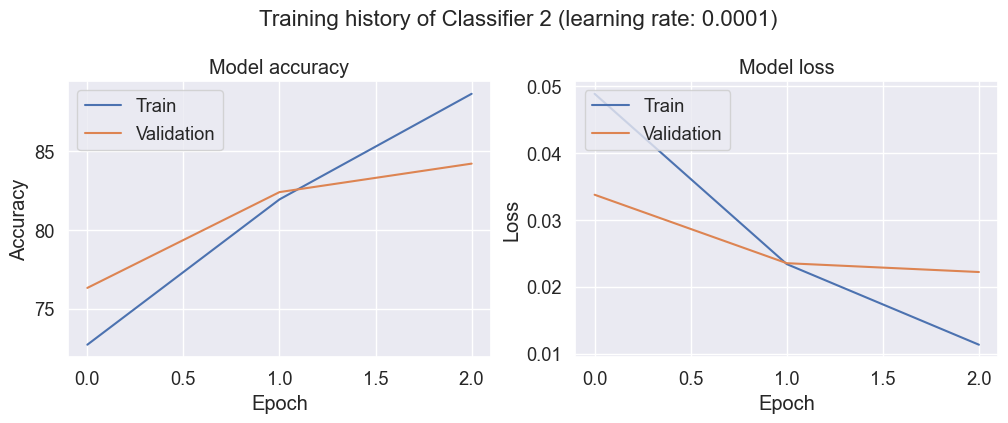

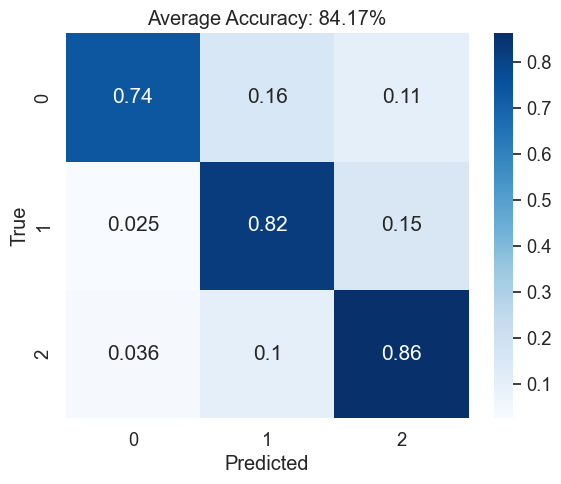

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Ray\anaconda3\envs\cv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be re

Start training...

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss   |   Val Acc    |  Elapsed 
------------------------------------------------------------------------------------------
   1    |   20    |   0.095937   |  51.488095   |     -       |      -       |   3.31   
   1    |   40    |   0.077508   |  58.750000   |     -       |      -       |   3.16   
   1    |   60    |   0.059519   |  72.500000   |     -       |      -       |   3.17   
   1    |   80    |   0.046365   |  74.687500   |     -       |      -       |   3.22   
   1    |   100   |   0.033994   |  80.625000   |     -       |      -       |   3.22   
   1    |   120   |   0.032738   |  77.187500   |     -       |      -       |   3.19   
   1    |   140   |   0.039934   |  72.812500   |     -       |      -       |   3.16   
   1    |   160   |   0.039304   |  77.187500   |     -       |      -       |   3.13   
   1    |   180   |   0.034412   |  77.500000   |     -       |      -       |   3.15   


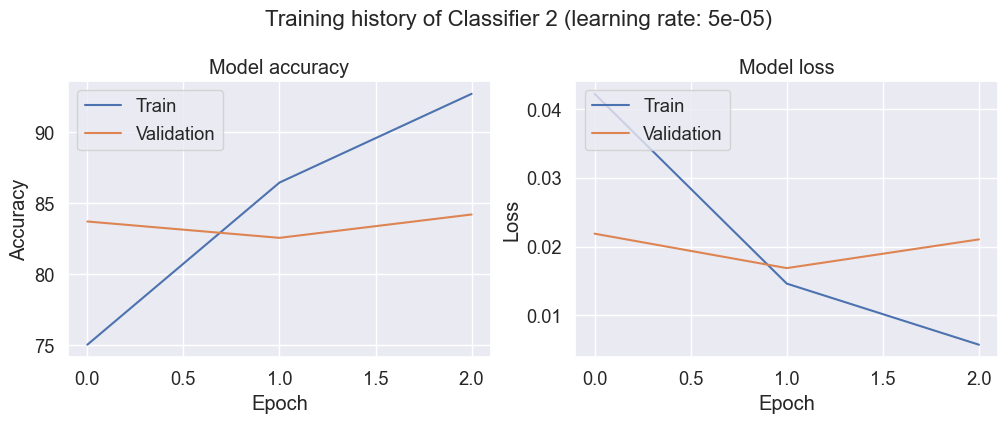

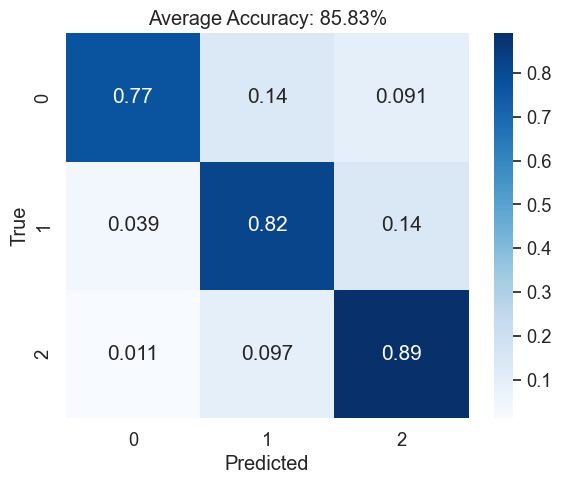

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
C:\Users\Ray\anaconda3\envs\cv\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be re

Start training...

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss   |   Val Acc    |  Elapsed 
------------------------------------------------------------------------------------------
   1    |   20    |   0.106377   |  48.511905   |     -       |      -       |   3.39   
   1    |   40    |   0.084310   |  56.875000   |     -       |      -       |   3.24   
   1    |   60    |   0.071421   |  63.125000   |     -       |      -       |   3.25   
   1    |   80    |   0.057931   |  76.875000   |     -       |      -       |   3.21   
   1    |   100   |   0.079654   |  64.687500   |     -       |      -       |   3.20   
   1    |   120   |   0.044225   |  78.437500   |     -       |      -       |   3.16   
   1    |   140   |   0.043058   |  77.187500   |     -       |      -       |   3.17   
   1    |   160   |   0.039743   |  77.812500   |     -       |      -       |   3.21   
   1    |   180   |   0.037696   |  76.562500   |     -       |      -       |   3.20   


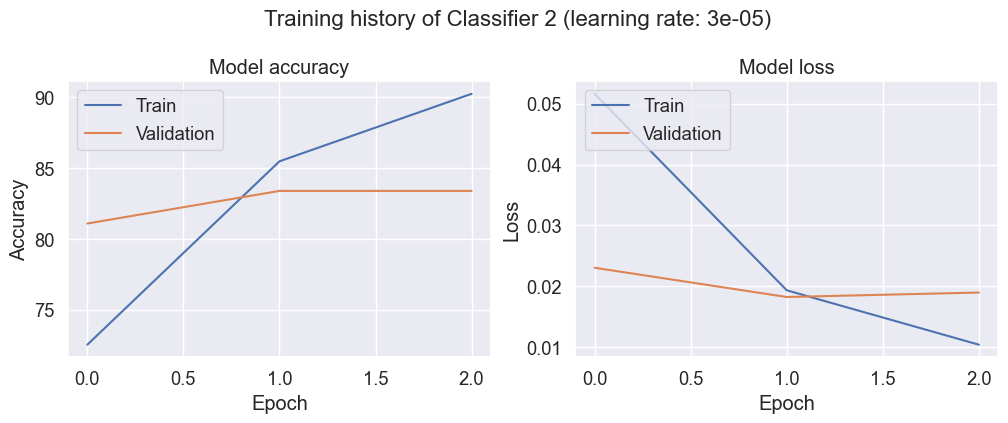

In [ ]:
learning_rates = [1e-4, 5e-5, 3e-5]
epochs_n = 3
for learning_rate in learning_rates: 
    bert_classifier, optimizer, scheduler = initialize_model(classifier, lr=learning_rate, epochs=epochs_n)
    epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc = train(bert_classifier, train_dataloader, val_dataloader, epochs=epochs_n, evaluation=True)
    
    plot_training_history(epoch_train_acc, epoch_val_acc, epoch_train_loss, epoch_val_loss, 'Classifier 2', learning_rate)
    # Compute predicted probabilities on the test set
    probs = bert_predict(bert_classifier, test_dataloader)
    y_pred = np.argmax(probs, axis=1)
    # # Evaluate the Bert classifier
    evaluate_matrix(y_pred, y_test)

In [41]:
# learning_rates = [5e-5]
# epochs_n = 3
# for learning_rate in learning_rates: 
#     bert_classifier, optimizer, scheduler = initialize_model(classifier, lr=learning_rate, epochs=epochs_n)
#     epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc = train(bert_classifier, train_dataloader, val_dataloader, epochs=epochs_n, evaluation=True)
    
#     plot_training_history(epoch_train_acc, epoch_val_acc, epoch_train_loss, epoch_val_loss, 'Classifier 2', learning_rate)
#     # Compute predicted probabilities on the test set
#     probs = bert_predict(bert_classifier, test_dataloader)
#     y_pred = np.argmax(probs, axis=1)
#     # # Evaluate the Bert classifier
#     evaluate_matrix(y_pred, y_test)

In [42]:
!ls

'ls' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


# Save Model


In [43]:
torch.save(bert_classifier, './Model/ABAS_model_2')

# Inference

In [44]:
def bert_predict_label(model, dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    y_pred = np.argmax(probs, axis=1)
    labels_decoded = encoder.inverse_transform(y_pred)
    
    return labels_decoded

In [45]:
# load model
saved_model_1 = torch.load('./Model/ABAS_model_1')
# saved_model_2 = torch.load('./Model/ABAS_model_2')

In [46]:
lables = bert_predict_label(saved_model_1, test_dataloader)
lables[0:11]

array(['NEU', 'NEU', 'POS', 'NEU', 'NEU', 'NEU', 'NEU', 'POS', 'POS',
       'POS', 'NEU'], dtype=object)

# Predict Rest Data

In [47]:
amusements

0                               Arab Street
1      Buddha Tooth Relic Temple and Museum
2                               Clarke Quay
3                        Gardens by the Bay
4                          Jurong Bird Park
5     ArtScience Museum at Marina Bay Sands
6                       Maxwell Food Centre
7                              Merlion Park
8                            Mustafa Centre
9              National Museum of Singapore
10                   National Orchid Garden
11                             Night Safari
12                             Orchard Road
13                            River Wonders
14           Sands Skypark Observation Deck
15                          Singapore Flyer
16                          Singapore River
17                            Singapore Zoo
18                Singapore Botanic Gardens
19        Singapore Mass Rapid Transit SMRT
Name: Place, dtype: object

In [ ]:
# load data
batch_size = 16
cols = ['place', 'reviewer', 'reviewer_location', 'reviewer_contributions',
       'review_rating', 'review_type', 'review_date', 'review_title',
       'review_text', 'review_preprocessed', 'aspect_term', 'aspect',
       ]

amusement_n = 0 
for amusement in amusements:
    amusement_n +=1
    print(f'{amusement_n} processing {amusement}')
    
    file = f'./SentenceInfer/infer-{amusement}.csv'
    output_file = f'./SentenceInferData/infer-label-{amusement}.csv'
    
    df = pd.read_csv(file)[cols]
    aspects = [aspect.replace('\'','').replace('[','').replace(']','') for aspect in df['aspect']]
    X = [ aspect + ' [SEP] ' + text for aspect, text in zip(df['aspect'], df['review_text'])]
    

    # Run function `preprocessing_for_bert` on the train set and the validation set
    print('Tokenizing data...')
    inputs, masks = preprocessing_for_bert(X)

    # Create the DataLoader 
    data = TensorDataset(inputs, masks)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size)

    print('Predicting label...')
    lables = bert_predict_label(saved_model_1, dataloader)
    df['sentiment'] = lables
    df.to_csv(output_file, index=False)
    
